# Training a simple linear regression model with dbt and fal

In [124]:
!dbt seed --profiles-dir ..

12:35:30  Running with dbt=1.4.4
12:35:30  Found 2 models, 0 tests, 0 snapshots, 0 analyses, 341 macros, 0 operations, 2 seed files, 0 sources, 0 exposures, 0 metrics
12:35:30  
12:35:31  Concurrency: 1 threads (target='staging')
12:35:31  
12:35:31  1 of 2 START seed file dbt_meder.raw_customer_order_data ....................... [RUN]
12:35:37  1 of 2 OK loaded seed file dbt_meder.raw_customer_order_data ................... [INSERT 50 in 5.39s]
12:35:37  2 of 2 START seed file dbt_meder.raw_customer_order_data_labeled ............... [RUN]
12:35:55  2 of 2 OK loaded seed file dbt_meder.raw_customer_order_data_labeled ........... [INSERT 1000 in 18.58s]
12:35:55  
12:35:55  Finished running 2 seeds in 0 hours 0 minutes and 24.96 seconds (24.96s).
12:35:55  
12:35:55  Completed successfully
12:35:55  
12:35:55  Done. PASS=2 WARN=0 ERROR=0 SKIP=0 TOTAL=2


In [18]:
!dbt run -s customer_orders customer_orders_labeled --profiles-dir ..

In [4]:
from fal import FalDbt
import matplotlib.pyplot as plt

In [19]:
faldbt = FalDbt("..", "..")

In [10]:
orders_df = faldbt.ref("customer_orders_labeled")
orders_df.head()

,order_id,customer_id,total_price,age,return
0,210.0,488.0,187.861698,18.0,0.0
1,263.0,578.0,628.745330,18.0,0.0
2,360.0,578.0,99.154886,18.0,0.0
3,482.0,818.0,393.284591,18.0,0.0
4,594.0,656.0,339.542104,18.0,0.0


In [9]:
print('Summary statistics:\n', orders_df.describe())

Summary statistics:
           order_id  customer_id  total_price         age       return
count  1000.000000   1000.00000  1000.000000  1000.00000  1000.000000
mean    499.500000    499.19500   508.766031    41.72000     0.203000
std     288.819436    284.65704   289.078945    13.44933     0.402434
min       0.000000      0.00000    12.121936    18.00000     0.000000
25%     249.750000    251.00000   252.136277    31.00000     0.000000
50%     499.500000    495.50000   499.654528    43.00000     0.000000
75%     749.250000    740.00000   764.379751    53.00000     0.000000
max     999.000000    999.00000   998.200204    64.00000     1.000000


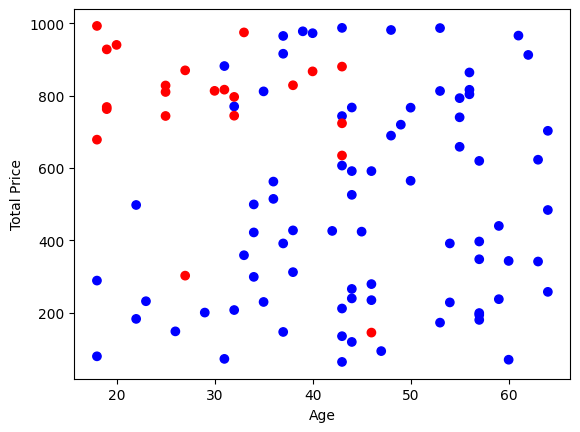

In [112]:
# Sample data for plot
plot_data = orders_df.sample(frac=0.1, random_state=123)

colors = ['red' if r else 'blue' for r in plot_data['return']]  # assign colors based on whether or not order was returned

plt.scatter(plot_data['age'], plot_data['total_price'], c=colors)
plt.xlabel('Age')
plt.ylabel('Total Price')
plt.show()

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train logistic regression model
X = orders_df[['age', 'total_price']]
y = orders_df['return']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

lr_model = LogisticRegression(random_state=123)
lr_model.fit(X_train, y_train)

# Test model
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.87      0.97      0.91       227
         1.0       0.85      0.53      0.66        73

    accuracy                           0.86       300
   macro avg       0.86      0.75      0.79       300
weighted avg       0.86      0.86      0.85       300



In [32]:
orders_new_df = faldbt.ref("customer_orders")

In [118]:
orders_new_df.head()

,order_id,customer_id,total_price,age
0,1037.0,981.0,193.460803,19.0
1,1027.0,940.0,680.986976,21.0
2,1039.0,123.0,952.906524,22.0
3,1043.0,860.0,545.791012,22.0
4,1046.0,316.0,887.003551,24.0


In [ ]:
models_df = faldbt.ref("order_return_prediction_models")
best_model_df = models_df[models_df.accuracy == models_df.accuracy.max()]
model_name = best_model_df.model_name[0]

In [30]:
import pickle
with open(f"../ml_models/{model_name}.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [33]:
predictions = loaded_model.predict(orders_new_df[["age", "total_price"]])
orders_new_df["predicted_return"] = predictions

In [35]:
orders_new_df.head()

,order_id,customer_id,total_price,age,predicted_return
0,1037.0,981.0,193.460803,19.0,0.0
1,1027.0,940.0,680.986976,21.0,1.0
2,1039.0,123.0,952.906524,22.0,1.0
3,1043.0,860.0,545.791012,22.0,1.0
4,1046.0,316.0,887.003551,24.0,1.0
